# Quantum Classifier

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

In this tutorial, we will discuss the workflow of Variational Quantum Classifiers (VQC) and how to use quantum neural networks (QNN) to accomplish a **binary classification** task. The main representatives of this approach include the [Quantum Circuit Learning (QCL)](https://arxiv.org/abs/1803.00745) [1] by Mitarai et al. (2018), Farhi & Neven (2018) [2] and [Circuit-Centric Quantum Classifiers](https://arxiv.org/abs/1804.00633) [3] by Schuld et al. (2018). Here, we mainly talk about classification in the language of supervised learning. Unlike classical methods, quantum classifiers require pre-processing to encode classical data into quantum data, and then train the parameters in the quantum neural network. Using different encoding methods, we can benchmark the optimal classification performance through test data. Finally, we demonstrate how to use built-in quantum datasets to accomplish quantum classification.

### Background

In the language of supervised learning, we need to enter a data set composed of $N$ pairs of labeled data points $D = \{(x^k,y^k)\}_{k=1}^{N}$ , Where $x^k\in \mathbb{R}^{m}$ is the data point, and $y^k \in\{0,1\}$ is the label associated with the data point $x^k$. **The classification process is essentially a decision-making process, which determines the label attribution of a given data point**. For the quantum classifier framework, the realization of the classifier $\mathcal{F}$ is a combination of a quantum neural network (or parameterized quantum circuit) with parameters $\theta$, measurement, and data processing. An excellent classifier $\mathcal{F}_\theta$ should correctly map the data points in each data set to the corresponding labels as accurate as possible $\mathcal{F}_\theta(x^k ) \rightarrow y^k$. Therefore, we use the cumulative distance between the predicted label $\tilde{y}^{k} = \mathcal{F}_\theta(x^k)$ and the actual label $y^k$ as the loss function $\mathcal {L}(\theta)$ to be optimized. For binary classification tasks, we can choose the following loss function,

$$
\mathcal{L}(\theta) = \sum_{k=1}^N 1/N \cdot |\tilde{y}^{k}-y^k|^2. \tag{1}
$$

### Pipeline

Here we give the whole pipeline to implement a quantum classifier under the framework of quantum circuit learning (QCL).

1. Encode the classical data $x^k$ to quantum data $\lvert \psi_{\rm in}\rangle^k$. In this tutorial, we use Angle Encoding, see [encoding methods](./DataEncoding_EN.ipynb) for details. Readers can also try other encoding methods, e.g., Amplitude Encoding, and see the performance.
2. Construct the parameterized quantum circuit (PQC), corresponds to the unitary gate $U(\theta)$.
3. Apply the parameterized circuit $U(\theta)$ with the parameter $\theta$ on input states $\lvert \psi_{\rm in} \rangle^k$, thereby obtaining the output state $\lvert \psi_{\rm out} \rangle^k = U(\theta)\lvert \psi_{\rm in} \rangle^k$.
4. Measure the quantum state $\lvert \psi_{\rm out}\rangle^k$ processed by the quantum neural network to get the estimated label $\tilde{y}^{k}$.
5. Repeat steps 3-4 until all data points in the data set have been processed. Then calculate the loss function $\mathcal{L}(\theta)$.
6. Continuously adjust the parameter $\theta$ through optimization methods such as gradient descent to minimize the loss function. Record the optimal parameters after optimization $\theta^* $, and then we obtain the optimal classifier $\mathcal{F}_{\theta^*}$.

<img src="./figures/qclassifier-fig-pipeline.png" width="700px" /> 
<center> Figure 1: Flow chart of quantum classifier training </center>

## Paddle Quantum Implementation

Here, we first import the required packages:

In [1]:
# Import numpy and paddle
import numpy as np
import paddle

# To construct quantum circuit
from paddle_quantum.circuit import UAnsatz
# Some functions
from numpy import pi as PI
from paddle import matmul, transpose, reshape  # paddle matrix multiplication and transpose
from paddle_quantum.utils import pauli_str_to_matrix, dagger  # N qubits Pauli matrix, complex conjugate

# Plot figures, calculate the run time
from matplotlib import pyplot as plt
import time

C:\Users\yeruilin\Anaconda3\envs\paddle_quantum_env\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


Parameters used for classification

In [2]:
# Parameters for generating the data set
Ntrain = 200        # Specify the training set size
Ntest = 100         # Specify the test set size
boundary_gap = 0.5  # Set the width of the decision boundary
seed_data = 2       # Fixed random seed required to generate the data set
# Parameters for training
N = 4               # Number of qubits required
DEPTH = 1           # Circuit depth
BATCH = 20          # Batch size during training
EPOCH = int(200 * BATCH / Ntrain)
                    # Number of training epochs, the total iteration number "EPOCH * (Ntrain / BATCH)" is chosen to be about 200
LR = 0.01           # Set the learning rate
seed_paras = 19     # Set random seed to initialize various parameters

### Data set generation

One of the key parts in supervised learning is what data set to use? In this tutorial, we follow the exact approach introduced in QCL paper to generate a simple binary data set $\{(x^{k}, y^{k})\}$ with circular decision boundary, where the data point $x^{k}\in \mathbb{R}^{2}$, and the label $y^{k} \in \{0,1\}$. The figure below provides us a concrete example.

<img src="./figures/qclassifier-fig-data.png" width="400px" /> 
<center> Figure 2: Generated data set and the corresponding decision boundary </center>

For the generation method and visualization, please see the following code:

Generate a binary classification data set

In [3]:
# Generate a binary classification data set with circular decision boundary
def circle_data_point_generator(Ntrain, Ntest, boundary_gap, seed_data):
    """
    :param Ntrain: number of training samples
    :param Ntest: number of test samples
    :param boundary_gap: value in (0, 0.5), means the gap between two labels
    :param seed_data: random seed
    :return: 'Ntrain' samples for training and
             'Ntest' samples for testing
    """
    # Generate "Ntrain + Ntest" pairs of data, x for 2-dim data points, y for labels.
    # The first "Ntrain" pairs are used as training set, the last "Ntest" pairs are used as testing set
    train_x, train_y = [], []
    num_samples, seed_para = 0, 0
    while num_samples < Ntrain + Ntest:
        np.random.seed((seed_data + 10) * 1000 + seed_para + num_samples)
        data_point = np.random.rand(2) * 2 - 1  # 2-dim vector in range [-1, 1]

        # If the modulus of the data point is less than (0.7 - gap), mark it as 0
        if np.linalg.norm(data_point) < 0.7-boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(0.)
            num_samples += 1

        # If the modulus of the data point is greater than (0.7 + gap), mark it as 1
        elif np.linalg.norm(data_point) > 0.7 + boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(1.)
            num_samples += 1
        else:
            seed_para += 1

    train_x = np.array(train_x).astype("float64")
    train_y = np.array([train_y]).astype("float64").T

    print("The dimensions of the training set x {} and y {}".format(np.shape(train_x[0:Ntrain]), np.shape(train_y[0:Ntrain])))
    print("The dimensions of the test set x {} and y {}".format(np.shape(train_x[Ntrain:]), np.shape(train_y[Ntrain:])), "\n")

    return train_x[0:Ntrain], train_y[0:Ntrain], train_x[Ntrain:], train_y[Ntrain:]

Visualize the generated data set

In [4]:
def data_point_plot(data, label):
    """
    :param data: shape [M, 2], means M 2-D data points
    :param label: value 0 or 1
    :return: plot these data points
    """
    dim_samples, dim_useless = np.shape(data)
    plt.figure(1)
    for i in range(dim_samples):
        if label[i] == 0:
            plt.plot(data[i][0], data[i][1], color="r", marker="o")
        elif label[i] == 1:
            plt.plot(data[i][0], data[i][1], color="b", marker="o")
    plt.show()

In this tutorial, we use a training set with 200 elements, a testing set with 100 elements. The boundary gap is 0.5.

The dimensions of the training set x (200, 2) and y (200, 1)
The dimensions of the test set x (100, 2) and y (100, 1) 

Visualization of 200 data points in the training set: 


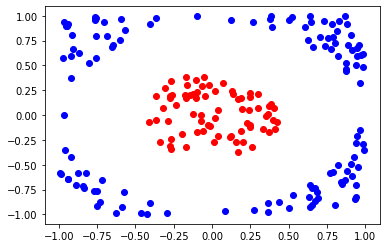

Visualization of 100 data points in the test set: 


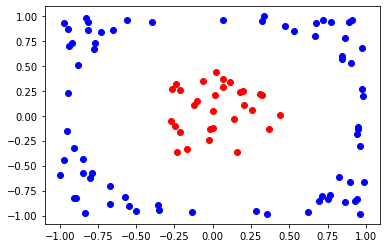


 You may wish to adjust the parameter settings to generate your own data set!


In [5]:
# Generate data set
train_x, train_y, test_x, test_y = circle_data_point_generator(
        Ntrain, Ntest, boundary_gap, seed_data)

# Visualization
print("Visualization of {} data points in the training set: ".format(Ntrain))
data_point_plot(train_x, train_y)
print("Visualization of {} data points in the test set: ".format(Ntest))
data_point_plot(test_x, test_y)
print("\n You may wish to adjust the parameter settings to generate your own data set!")

### Data preprocessing
Different from classical machine learning, quantum classifiers need to consider data preprocessing heavily. We need one more step to convert classical data into quantum information before running on a quantum computer. In this tutorial we use "Angle Encoding" to get quantum data.

First, we determine the number of qubits that need to be used. Because our data $\{x^{k} = (x^{k}_0, x^{k}_1)\}$ is two-dimensional, according to the paper by Mitarai (2018) we need at least 2 qubits for encoding. Then prepare a group of initial quantum states $|00\rangle$. Encode the classical information $\{x^{k}\}$ into a group of quantum gates $U(x^{k})$ and act them on the initial quantum states. Finally we get a group of quantum states $|\psi_{\rm in}\rangle^k = U(x^{k})|00\rangle$. In this way, we have completed the encoding from classical information into quantum information! Given $m$ qubits to encode a two-dimensional classical data point, the quantum gate is:

$$
U(x^{k}) = \otimes_{j=0}^{m-1} R_j^z\big[\arccos(x^{k}_{j \, \text{mod} \, 2}\cdot x^{k}_{j \, \text{mod} \, 2})\big] R_j^y\big[\arcsin(x^{k}_{j \, \text{mod} \, 2}) \big],
\tag{2}
$$

**Note:** In this representation, we count the first qubit as $j = 0$. For more encoding methods, see [Robust data encodings for quantum classifiers](https://arxiv.org/pdf/2003.01695.pdf). We also provide several built-in [encoding methods](./DataEncoding_EN.ipynb) in Paddle Quantum. Here we also encourage readers to try new encoding methods by themselves!

Since this encoding method looks quite complicated, we might as well give a simple example. Suppose we are given a data point $x = (x_0, x_1)= (1,0)$. The label of this data point should be 1, corresponding to the **blue** point in the figure above. At the same time, the 2-qubit quantum gate $U(x)$ corresponding to the data point is,

$$
U(x) =
\bigg( R_0^z\big[\arccos(x_{0}\cdot x_{0})\big] R_0^y\big[\arcsin(x_{0}) \big] \bigg)
\otimes
\bigg( R_1^z\big[\arccos(x_{1}\cdot x_{1})\big] R_1^y\big[\arcsin(x_{1}) \big] \bigg),
\tag{3}
$$

Substituting in specific values, we get:

$$
U(x) =
\bigg( R_0^z\big[0\big] R_0^y\big[\pi/2 \big] \bigg)
\otimes
\bigg( R_1^z\big[\pi/2\big] R_1^y\big[0 \big] \bigg),
\tag{4}
$$

Recall the matrix form of rotation gates:

$$
R_x(\theta) :=
\begin{bmatrix}
\cos \frac{\theta}{2} &-i\sin \frac{\theta}{2} \\
-i\sin \frac{\theta}{2} &\cos \frac{\theta}{2}
\end{bmatrix}
,\quad
R_y(\theta) :=
\begin{bmatrix}
\cos \frac{\theta}{2} &-\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} &\cos \frac{\theta}{2}
\end{bmatrix}
,\quad
R_z(\theta) :=
\begin{bmatrix}
e^{-i\frac{\theta}{2}} & 0 \\
0 & e^{i\frac{\theta}{2}}
\end{bmatrix}.
\tag{5}
$$

Then the matrix form of the two-qubit quantum gate $U(x)$ can be written as

$$
U(x) = 
\bigg(
\begin{bmatrix}
1 & 0 \\ 
0 & 1
\end{bmatrix}
\begin{bmatrix}
\cos \frac{\pi}{4} &-\sin \frac{\pi}{4} \\ 
\sin \frac{\pi}{4} &\cos \frac{\pi}{4} 
\end{bmatrix}
\bigg)
\otimes 
\bigg(
\begin{bmatrix}
e^{-i\frac{\pi}{4}} & 0 \\ 
0 & e^{i\frac{\pi}{4}}
\end{bmatrix}
\begin{bmatrix}
1 &0 \\ 
0 &1
\end{bmatrix}
\bigg) \, .
\tag{6}
$$

After simplification, we can get the encoded quantum state $|\psi_{\rm in}\rangle$ by acting the quantum gate on the initialized quantum state $|00\rangle$,

$$
|\psi_{\rm in}\rangle =
U(x)|00\rangle = \frac{1}{2}
\begin{bmatrix}
1-i &0 &-1+i &0 \\
0 &1+i &0 &-1-i \\
1-i &0 &1-i &0 \\
0 &1+i &0 &1+i
\end{bmatrix}
\begin{bmatrix}
1 \\
0 \\
0 \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}.
\tag{7}
$$

Then let us take a look at how to implement this encoding method in Paddle Quantum. Note that in the code, we use the following trick: 

$$
(U_1 |0\rangle)\otimes (U_2 |0\rangle) = (U_1 \otimes U_2) |0\rangle\otimes|0\rangle
= (U_1 \otimes U_2) |00\rangle.
\tag{8}
$$

In [6]:
# Gate: rotate around Y-axis, Z-axis with angle theta
def Ry(theta):
    """
    :param theta: parameter
    :return: Y rotation matrix
    """
    return np.array([[np.cos(theta / 2), -np.sin(theta / 2)],
                     [np.sin(theta / 2), np.cos(theta / 2)]])

def Rz(theta):
    """
    :param theta: parameter
    :return: Z rotation matrix
    """
    return np.array([[np.cos(theta / 2) - np.sin(theta / 2) * 1j, 0],
                     [0, np.cos(theta / 2) + np.sin(theta / 2) * 1j]])

# Classical -> Quantum Data Encoder
def datapoints_transform_to_state(data, n_qubits):
    """
    :param data: shape [-1, 2]
    :param n_qubits: the number of qubits to which
    the data transformed
    :return: shape [-1, 1, 2 ^ n_qubits]
        the first parameter -1 in this shape means can be arbitrary. In this tutorial, it equals to BATCH.
    """
    dim1, dim2 = data.shape
    res = []
    for sam in range(dim1):
        res_state = 1.
        zero_state = np.array([[1, 0]])
        # Angle Encoding
        for i in range(n_qubits):
            # For even number qubits, perform Rz(arccos(x0^2)) Ry(arcsin(x0))
            if i % 2 == 0:
                state_tmp=np.dot(zero_state, Ry(np.arcsin(data[sam][0])).T)
                state_tmp=np.dot(state_tmp, Rz(np.arccos(data[sam][0] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
            # For odd number qubits, perform Rz(arccos(x1^2)) Ry(arcsin(x1))
            elif i% 2 == 1:
                state_tmp=np.dot(zero_state, Ry(np.arcsin(data[sam][1])).T)
                state_tmp=np.dot(state_tmp, Rz(np.arccos(data[sam][1] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
        res.append(res_state)
    res = np.array(res)

    return res.astype("complex128")

quantum data after angle encoding

In [7]:
print("As a test, we enter the classical information:")
print("(x_0, x_1) = (1, 0)")
print("The 2-qubit quantum state output after encoding is:")
print(datapoints_transform_to_state(np.array([[1, 0]]), n_qubits=2))

As a test, we enter the classical information:
(x_0, x_1) = (1, 0)
The 2-qubit quantum state output after encoding is:
[[[0.5-0.5j 0. +0.j  0.5-0.5j 0. +0.j ]]]


### Building Quantum Neural Network 
After completing the encoding from classical data to quantum data, we can now input these quantum states into the quantum computer. Before that, we also need to design the quantum neural network.

<img src="./figures/qclassifier-fig-circuit.png" width="600px" /> 
<center> Figure 3: Parameterized Quantum Circuit </center>


For convenience, we call the parameterized quantum neural network as $U(\boldsymbol{\theta})$. $U(\boldsymbol{\theta})$ is a key component of our classifier, and it needs a certain complex structure to fit our decision boundary. Similar to traditional neural networks, the structure of a quantum neural network is not unique. The structure shown above is just one case. You could design your own structure. Let's take the previously mentioned data point $x = (x_0, x_1)= (1,0)$ as an example. After encoding, we have obtained a quantum state $|\psi_{\rm in}\rangle$,

$$
|\psi_{\rm in}\rangle =
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}.
\tag{9}
$$

Then we input this quantum state into our quantum neural network (QNN). That is, multiply a unitary matrix by a vector to get the processed quantum state $|\varphi\rangle$

$$
|\psi_{\rm out}\rangle = U(\boldsymbol{\theta})|\psi_{\rm in}\rangle.
\tag{10}
$$

If we set all the QNN parameters to be $\theta = \pi$, then we can write down the resulting state:

$$
|\psi_{\rm out}\rangle =
U(\boldsymbol{\theta} =\pi)|\psi_{\rm in}\rangle =
\begin{bmatrix}
0 &0 &-1 &0 \\
-1 &0 &0 &0 \\
0 &1 &0 &0 \\
0 &0 &0 &1
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}.
\tag{11}
$$

In [11]:
# Simulation of building a quantum neural network
def cir_Classifier(theta, n, depth):
    """
    :param theta: dim: [n, depth + 3], "+3" because we add an initial generalized rotation gate to each qubit
    :param n: number of qubits
    :param depth: circuit depth
    :return: U_theta
    """
    # Initialize the network
    cir = UAnsatz(n)
    
    # Build a generalized rotation layer
    for i in range(n):
        cir.rz(theta[i][0], i)
        cir.ry(theta[i][1], i)
        cir.rz(theta[i][2], i)

    # The default depth is depth = 1
    # Build the entangleed layer and Ry rotation layer
    for d in range(3, depth + 3):
        # The entanglement layer
        for i in range(n-1):
            cir.cnot([i, i + 1])
        cir.cnot([n-1, 0])
        # Add Ry to each qubit
        for i in range(n):
            cir.ry(theta[i][d], i)

    return cir

### Measurement
After passing through the PQC $U(\theta)$, the quantum data becomes $\lvert \psi_{\rm out}\rangle^k = U(\theta)\lvert \psi_{\rm in} \rangle^k$. To get its label, we need to measure this new quantum state to obtain the classical information. These processed classical information will then be used to calculate the loss function $\mathcal{L}(\boldsymbol{\theta})$. Finally, based on the gradient descent algorithm, we continuously update the PQC parameters $\boldsymbol{\theta}$ and optimize the loss function. 

Here we measure the expected value of the Pauli $Z$ operator on the first qubit. Specifically,

$$
\langle Z \rangle =
\langle \psi_{\rm out} |Z\otimes I\cdots \otimes I| \psi_{\rm out}\rangle.
\tag{12}
$$

Recall that the matrix of the Pauli $Z$ operator is defined as:

$$
Z := \begin{bmatrix} 1 &0 \\ 0 &-1 \end{bmatrix}.
\tag{13}
$$

Continuing our previous 2-qubit example, the expected value we get after the measurement is

$$
\langle Z \rangle =
\langle \psi_{\rm out} |Z\otimes I| \psi_{\rm out}\rangle =
\frac{1}{2}
\begin{bmatrix}
-1-i \quad
-1-i \quad
0 \quad
0
\end{bmatrix}
\begin{bmatrix}
1 &0 &0 &0 \\
0 &1 &0 &0 \\
0 &0 &-1 &0 \\
0 &0 &0 &-1
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}
= 1. \tag{14}
$$

This measurement result seems to be our original label 1. Does this mean that we have successfully classified this data point? This is not the case because the range of $\langle Z \rangle$ is usually between $[-1,1]$. 
To match it to our label range $y^{k} \in \{0,1\}$, we need to map the upper and lower limits. The simplest mapping is 

$$
\tilde{y}^{k} = \frac{\langle Z \rangle}{2} + \frac{1}{2} + bias \quad \in [0, 1].
\tag{15}
$$

Using bias is a trick in machine learning. The purpose is to make the decision boundary not restricted by the origin or some hyperplane. Generally, the default bias is initialized to be 0, and the optimizer will continuously update it like all the other parameters $\theta$ in the iterative process to ensure $\tilde{y}^{k} \in [0, 1]$. Of course, you can also choose other complex mappings (activation functions), such as the sigmoid function. After mapping, we can regard $\tilde{y}^{k}$ as the label we estimated. $\tilde{y}^{k}< 0.5$ corresponds to label 0, and $\tilde{y}^{k}> 0.5$ corresponds to label 1. It's time to quickly review the whole process before we finish discussion,

$$
x^{k} \rightarrow |\psi_{\rm in}\rangle^{k} \rightarrow U(\boldsymbol{\theta})|\psi_{\rm in}\rangle^{k} \rightarrow
|\psi_{\rm out}\rangle^{k} \rightarrow ^{k}\langle \psi_{\rm out} |Z\otimes I\cdots \otimes I| \psi_{\rm out} \rangle^{k}
\rightarrow \langle Z \rangle  \rightarrow \tilde{y}^{k}.\tag{16}
$$




###  Loss function

To calculate the loss function in Eq. (1), we need to measure all training data in each iteration. In real practice, we devide the training data into "Ntrain/BATCH" groups, where each group contains "BATCH" data pairs.

The loss function for the i-th group is 
$$
\mathcal{L}_{i} = \sum_{k=1}^{BATCH} \frac{1}{BATCH} |y^{i,k} - \tilde{y}^{i,k}|^2,\tag{17}
$$
and we train the PQC with $\mathcal{L}_{i}$ for "EPOCH" times. 

If you set "BATCH = Ntrain", there will be only one group, and Eq. (17) becomes Eq. (1).

In [6]:
# Generate Pauli Z operator that only acts on the first qubit
# Act the identity matrix on rest of the qubits
def Observable(n):
    r"""
    :param n: number of qubits
    :return: local observable: Z \otimes I \otimes ...\otimes I
    """
    Ob = pauli_str_to_matrix([[1.0,'z0']], n)

    return Ob

In [7]:
# Build the computational graph
class Opt_Classifier(paddle.nn.Layer):
    """
    Construct the model net
    """
    def __init__(self, n, depth, seed_paras=1, dtype='float64'):
        # Initialization, use n, depth give the initial PQC
        super(Opt_Classifier, self).__init__()
        self.n = n
        self.depth = depth
        # Initialize the parameters theta with a uniform distribution of [0, 2*pi]
        self.theta = self.create_parameter(
            shape=[n, depth + 3],  # "+3" because we add an initial generalized rotation gate to each qubit
            default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*PI),
            dtype=dtype,
            is_bias=False)
        # Initialize bias
        self.bias = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype=dtype,
            is_bias=False)

    # Define forward propagation mechanism, and then calculate loss function and cross-validation accuracy
    def forward(self, state_in, label):
        """
        Args:
            state_in: The input quantum state, shape [-1, 1, 2^n] -- in this tutorial: [BATCH, 1, 2^n]
            label: label for the input state, shape [-1, 1]
        Returns:
            The loss:
                L = 1/BATCH * ((<Z> + 1)/2 + bias - label)^2
        """
        # Convert Numpy array to tensor
        Ob = paddle.to_tensor(Observable(self.n))
        label_pp = reshape(paddle.to_tensor(label), [-1, 1])

        # Build the quantum circuit
        cir = cir_Classifier(self.theta, n=self.n, depth=self.depth)
        Utheta = cir.U

        # Because Utheta is achieved by learning, we compute with row vectors to speed up without affecting the training effect
        state_out = matmul(state_in, Utheta)  # shape:[-1, 1, 2 ** n], the first parameter is BATCH in this tutorial

        # Measure the expectation value of Pauli Z operator <Z> -- shape [-1,1,1]
        E_Z = matmul(matmul(state_out, Ob), transpose(paddle.conj(state_out), perm=[0, 2, 1]))

        # Mapping <Z> to the estimated value of the label
        state_predict = paddle.real(E_Z)[:, 0] * 0.5 + 0.5 + self.bias  # |y^{i,k} - \tilde{y}^{i,k}|^2
        loss = paddle.mean((state_predict - label_pp) ** 2)  # Get average for "BATCH" |y^{i,k} - \tilde{y}^{i,k}|^2: L_i：shape:[1,1]

        # Calculate the accuracy of cross-validation
        is_correct = (paddle.abs(state_predict - label_pp) < 0.5).nonzero().shape[0]
        acc = is_correct / label.shape[0]

        return loss, acc, state_predict.numpy(), cir

### Training process

After defining all the concepts above, we might take a look at the actual training process.

In [11]:
# Draw the figure of the final training classifier
def heatmap_plot(Opt_Classifier, N):
    # generate data points x_y_
    Num_points = 30
    x_y_ = []
    for row_y in np.linspace(0.9, -0.9, Num_points):
        row = []
        for row_x in np.linspace(-0.9, 0.9, Num_points):
            row.append([row_x, row_y])
        x_y_.append(row)
    x_y_ = np.array(x_y_).reshape(-1, 2).astype("float64")

    # make prediction: heat_data
    input_state_test = paddle.to_tensor(
        datapoints_transform_to_state(x_y_, N))
    loss_useless, acc_useless, state_predict, cir = Opt_Classifier(state_in=input_state_test, label=x_y_[:, 0])
    heat_data = state_predict.reshape(Num_points, Num_points)

    # plot
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    x_label = np.linspace(-0.9, 0.9, 3)
    y_label = np.linspace(0.9, -0.9, 3)
    ax.set_xticks([0, Num_points // 2, Num_points - 1])
    ax.set_xticklabels(x_label)
    ax.set_yticks([0, Num_points // 2, Num_points - 1])
    ax.set_yticklabels(y_label)
    im = ax.imshow(heat_data, cmap=plt.cm.RdBu)
    plt.colorbar(im)
    plt.show()

Learn the PQC via Adam

In [12]:
def QClassifier(Ntrain, Ntest, gap, N, DEPTH, EPOCH, LR, BATCH, seed_paras, seed_data):
    """
    Quantum Binary Classifier
    Input:
        Ntrain         # Specify the training set size
        Ntest          # Specify the test set size
        gap            # Set the width of the decision boundary
        N              # Number of qubits required
        DEPTH          # Circuit depth
        BATCH          # Batch size during training
        EPOCH          # Number of training epochs, the total iteration number "EPOCH * (Ntrain / BATCH)" is chosen to be about 200
        LR             # Set the learning rate
        seed_paras     # Set random seed to initialize various parameters
        seed_data      # Fixed random seed required to generate the data set
        plot_heat_map  # Whether to plot heat map, default True
    """
    # Generate data set
    train_x, train_y, test_x, test_y = circle_data_point_generator(Ntrain=Ntrain, Ntest=Ntest, boundary_gap=gap, seed_data=seed_data)
    # Read the dimension of the training set
    N_train = train_x.shape[0]
    
    paddle.seed(seed_paras)
    # Initialize the registers to store the accuracy rate and other information
    summary_iter, summary_test_acc = [], []

    # Generally, we use Adam optimizer to get relatively good convergence
    # Of course, it can be changed to SGD or RMSprop
    myLayer = Opt_Classifier(n=N, depth=DEPTH)  # Initial PQC
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=myLayer.parameters())


    # Optimize iteration
    # We divide the training set into "Ntrain/BATCH" groups
    # For each group the final circuit will be used as the initial circuit for the next group
    # Use cir to record the final circuit after learning.
    i = 0  # Record the iteration number
    for ep in range(EPOCH):
        # Learn for each group
        for itr in range(N_train // BATCH):
            i += 1  # Record the iteration number
            # Encode classical data into a quantum state |psi>, dimension [BATCH, 2 ** N]
            input_state = paddle.to_tensor(datapoints_transform_to_state(train_x[itr * BATCH:(itr + 1) * BATCH], N))

            # Run forward propagation to calculate loss function
            loss, train_acc, state_predict_useless, cir \
                = myLayer(state_in=input_state, label=train_y[itr * BATCH:(itr + 1) * BATCH])  # optimize the given PQC
            # Print the performance in iteration
            if i % 30 == 5:
                # Calculate the correct rate on the test set test_acc
                input_state_test = paddle.to_tensor(datapoints_transform_to_state(test_x, N))
                loss_useless, test_acc, state_predict_useless, t_cir \
                    = myLayer(state_in=input_state_test,label=test_y)
                print("epoch:", ep, "iter:", itr,
                      "loss: %.4f" % loss.numpy(),
                      "train acc: %.4f" % train_acc,
                      "test acc: %.4f" % test_acc)
                # Store accuracy rate and other information
                summary_iter.append(itr + ep * N_train)
                summary_test_acc.append(test_acc) 

            # Run back propagation to minimize the loss function
            loss.backward()
            opt.minimize(loss)
            opt.clear_grad()
            
    # Print the final circuit
    print("The trained circuit:")
    print(cir)
    # Draw the decision boundary represented by heatmap
    heatmap_plot(myLayer, N=N)

    return summary_test_acc

The dimensions of the training set x (200, 2) and y (200, 1)
The dimensions of the test set x (100, 2) and y (100, 1) 

epoch: 0 iter: 4 loss: 0.1547 train acc: 0.8500 test acc: 0.6400
epoch: 3 iter: 4 loss: 0.1337 train acc: 0.9500 test acc: 0.8800
epoch: 6 iter: 4 loss: 0.1265 train acc: 1.0000 test acc: 1.0000
epoch: 9 iter: 4 loss: 0.1247 train acc: 1.0000 test acc: 1.0000
epoch: 12 iter: 4 loss: 0.1261 train acc: 1.0000 test acc: 1.0000
epoch: 15 iter: 4 loss: 0.1268 train acc: 1.0000 test acc: 1.0000
epoch: 18 iter: 4 loss: 0.1269 train acc: 1.0000 test acc: 1.0000
The trained circuit:
--Rz(0.542)----Ry(3.458)----Rz(2.692)----*--------------x----Ry(6.191)--
                                         |              |               
--Rz(3.514)----Ry(1.543)----Rz(2.499)----x----*---------|----Ry(2.968)--
                                              |         |               
--Rz(5.947)----Ry(3.161)----Rz(3.897)---------x----*----|----Ry(1.579)--
                                    

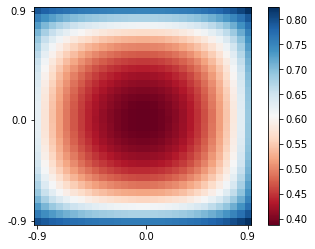

The main program finished running in  8.05081820487976 seconds.


In [13]:
def main():
    """
    main
    """
    time_start = time.time()
    acc = QClassifier(
        Ntrain = 200,    # Specify the training set size
        Ntest = 100,     # Specify the test set size
        gap = 0.5,       # Set the width of the decision boundary
        N = 4,           # Number of qubits required
        DEPTH = 1,       # Circuit depth
        BATCH = 20,      # Batch size during training
        EPOCH = int(200 * BATCH / Ntrain),
                        # Number of training epochs, the total iteration number "EPOCH * (Ntrain / BATCH)" is chosen to be about 200
        LR = 0.01,       # Set the learning rate
        seed_paras = 19, # Set random seed to initialize various parameters
        seed_data = 2,   # Fixed random seed required to generate the data set
    )
    
    time_span = time.time()-time_start
    print('The main program finished running in ', time_span, 'seconds.')

if __name__ == '__main__':
    main()

By printing out the training results, you can see that the classification accuracy in the test set and the data set after continuous optimization has reached $100\%$.

## Benchmarking Different Encoding Methods

Encoding methods are fundemental in supervised quantum machine learning [4]. In paddle quantum, commonly used encoding methods such as amplitude encoding, angle encoding, IQP encoding, etc., are integrated. Simple classification data of users (without reducing dimensions) can be encoded by an instance of the ``SimpleDataset`` class and image data can be encoded by an instance of the ``VisionDataset`` class both using the method ``encode``.

In [8]:
# Use circle data above to accomplish classification
from paddle_quantum.dataset import *

# The data are two-dimensional and are encoded by two qubits
quantum_train_x = SimpleDataset(2).encode(train_x, 'angle_encoding', 2)
quantum_test_x = SimpleDataset(2).encode(test_x, 'angle_encoding', 2)

print(type(quantum_test_x)) # ndarray
print(quantum_test_x.shape) # (100, 4)

<class 'numpy.ndarray'>
(100, 4)


Here we define an ordinary classifier, and it will be used by different data afterwards.

In [20]:
# A simpler classifier
def QClassifier2(quantum_train_x, train_y,quantum_test_x,test_y, N, DEPTH, EPOCH, LR, BATCH):
    """
    Quantum Binary Classifier
    Input：
        quantum_train_x     # training x
        train_y             # training y
        quantum_test_x      # testing x
        test_y              # testing y
        N                   # Number of qubits required
        DEPTH               # Circuit depth
        EPOCH               # Number of training epochs
        LR                  # Set the learning rate
        BATCH               # Batch size during training
    """
    Ntrain = len(quantum_train_x)
    
    paddle.seed(1)

    net = Opt_Classifier(n=N, depth=DEPTH)

    # Test accuracy list
    summary_iter, summary_test_acc = [], []

    # Adam can also be replaced by SGD or RMSprop
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

    # Optimize
    for ep in range(EPOCH):
        for itr in range(Ntrain // BATCH):
            # Import data
            input_state = quantum_train_x[itr * BATCH:(itr + 1) * BATCH]  # paddle.tensor
            input_state = reshape(input_state, [-1, 1, 2 ** N])
            label = train_y[itr * BATCH:(itr + 1) * BATCH]
            test_input_state = reshape(quantum_test_x, [-1, 1, 2 ** N])

            loss, train_acc, state_predict_useless, cir = net(state_in=input_state, label=label)

            if itr % 5 == 0:
                # get accuracy on test dataset (test_acc)
                loss_useless, test_acc, state_predict_useless, t_cir = net(state_in=test_input_state, label=test_y)
                print("epoch:", ep, "iter:", itr,
                      "loss: %.4f" % loss.numpy(),
                      "train acc: %.4f" % train_acc,
                      "test acc: %.4f" % test_acc)
                summary_test_acc.append(test_acc)

            loss.backward()
            opt.minimize(loss)
            opt.clear_grad()

    return summary_test_acc

Now we can test different encoding methods on the circle data generated above. Here we choose five encoding methods: amplitude encoding, angle encoding, pauli rotation encoding, IQP encoding, and complex entangled encoding. Then the curves of the testing accuracy are shown below.

In [21]:
# Testing different encoding methods
encoding_list = ['amplitude_encoding', 'angle_encoding', 'pauli_rotation_encoding', 'IQP_encoding', 'complex_entangled_encoding']
num_qubit = 2 # If qubit number is 1, CNOT gate in cir_classifier can not be used
dimension = 2
acc_list = []

for i in range(len(encoding_list)):
    encoding = encoding_list[i]
    print("Encoding method:", encoding)
    # Use SimpleDataset to encode the data
    quantum_train_x= SimpleDataset(dimension).encode(train_x, encoding, num_qubit)
    quantum_test_x= SimpleDataset(dimension).encode(test_x, encoding, num_qubit)
    quantum_train_x = paddle.to_tensor(quantum_train_x)
    quantum_test_x = paddle.to_tensor(quantum_test_x)
    
    acc = QClassifier2(
            quantum_train_x, # Training x
            train_y,         # Training y
            quantum_test_x,  # Testing x
            test_y,          # Testing y
            N = num_qubit,   # Number of qubits required
            DEPTH = 1,       # Circuit depth
            EPOCH = 1,       # Number of training epochs
            LR = 0.1,        # Set the learning rate
            BATCH = 10,      # Batch size during training
          )
    acc_list.append(acc)

Encoding method: amplitude_encoding
epoch: 0 iter: 0 loss: 0.3066 train acc: 0.4000 test acc: 0.5400
epoch: 0 iter: 5 loss: 0.2378 train acc: 0.7000 test acc: 0.7000
epoch: 0 iter: 10 loss: 0.2308 train acc: 0.8000 test acc: 0.6700
epoch: 0 iter: 15 loss: 0.2230 train acc: 0.8000 test acc: 0.6100
Encoding method: angle_encoding
epoch: 0 iter: 0 loss: 0.2949 train acc: 0.5000 test acc: 0.3600
epoch: 0 iter: 5 loss: 0.1770 train acc: 0.7000 test acc: 0.7000
epoch: 0 iter: 10 loss: 0.1654 train acc: 0.8000 test acc: 0.7000
epoch: 0 iter: 15 loss: 0.1966 train acc: 0.7000 test acc: 0.5800
Encoding method: pauli_rotation_encoding
epoch: 0 iter: 0 loss: 0.2433 train acc: 0.6000 test acc: 0.7000
epoch: 0 iter: 5 loss: 0.2142 train acc: 0.7000 test acc: 0.7000
epoch: 0 iter: 10 loss: 0.2148 train acc: 0.7000 test acc: 0.7000
epoch: 0 iter: 15 loss: 0.2019 train acc: 0.8000 test acc: 0.7600
Encoding method: IQP_encoding
epoch: 0 iter: 0 loss: 0.2760 train acc: 0.6000 test acc: 0.4200
epoch: 0 i

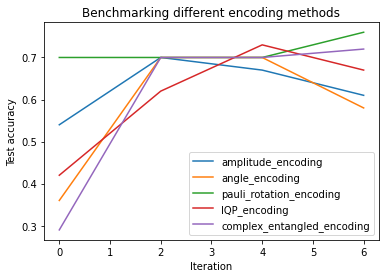

In [22]:
# Benchmarking different encoding methods
x=[2*i for i in range(len(acc_list[0]))]
for i in range(len(encoding_list)):
    plt.plot(x,acc_list[i])
plt.legend(encoding_list)
plt.title("Benchmarking different encoding methods")
plt.xlabel("Iteration")
plt.ylabel("Test accuracy")
plt.show()

## Quantum Classification on Built-In MNIST and Iris Datasets

Paddle Quantum provides datasets commonly used in quantum classification tasks, and users can use the `paddle_quantum.dataset` module to get the encoding circuits or encoded states. There are four built-in datasets in Paddle Quantum at present, including MNIST, FashionMNIST, Iris and BreastCancer. We can easily accomplishing quantum classification using these quantum datasets.

The first case is Iris. It has three types of labels and 50 samples of each type. There are only four features in Iris data, and it is very easy to fulfill its classification.

C:\Users\yeruilin\Anaconda3\envs\paddle_quantum_env\lib\site-packages\paddle\fluid\dygraph\math_op_patch.py:237: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float64, but right dtype is paddle.int32, the right dtype will convert to paddle.float64
  warnings.warn(


epoch: 0 iter: 0 loss: 0.3113 train acc: 0.0000 test acc: 0.0000
epoch: 0 iter: 5 loss: 0.4818 train acc: 0.0000 test acc: 0.3500
epoch: 0 iter: 10 loss: 0.2171 train acc: 1.0000 test acc: 1.0000
epoch: 0 iter: 15 loss: 0.1688 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 0 loss: 0.1350 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 5 loss: 0.1110 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 10 loss: 0.0879 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 15 loss: 0.0490 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 0 loss: 0.0733 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 5 loss: 0.0740 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 10 loss: 0.0660 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 15 loss: 0.0394 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 0 loss: 0.0654 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 5 loss: 0.0557 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 10 loss: 0.0602 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 15 

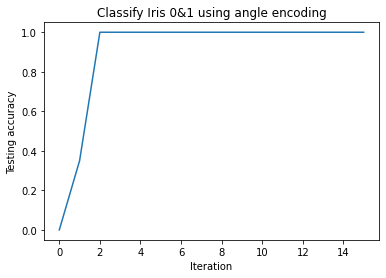

In [23]:
# Using Iris
test_rate = 0.2
num_qubit = 4

# acquire Iris data as quantum states
iris =Iris (encoding='angle_encoding', num_qubits=num_qubit, test_rate=test_rate,classes=[0, 1], return_state=True)

quantum_train_x, train_y = iris.train_x, iris.train_y
quantum_test_x, test_y = iris.test_x, iris.test_y
testing_data_num = len(test_y)
training_data_num = len(train_y)

acc = QClassifier2(
        quantum_train_x, # training x
        train_y,         # training y
        quantum_test_x,  # testing x
        test_y,          # testing y
        N = num_qubit,   # Number of qubits required
        DEPTH = 1,       # Circuit depth
        EPOCH = 4,       # Number of training epochs, the total iteration number "EPOCH * (Ntrain / BATCH)" is chosen to be about 200
        LR = 0.1,        # Set the learning rate
        BATCH = 4,       # Batch size during training
      )
plt.plot(acc)
plt.title("Classify Iris 0&1 using angle encoding")
plt.xlabel("Iteration")
plt.ylabel("Testing accuracy")
plt.show()

The second case is MNIST. It is a handwritten digit dataset and has 10 classes. Each figure has $28\times28$ pixels, and downscaling methods such as ``resize`` and ``PCA`` should be used to transform it into the target dimension.

epoch: 0 iter: 0 loss: 0.3237 train acc: 0.3250 test acc: 0.5450
epoch: 0 iter: 5 loss: 0.2124 train acc: 0.7500 test acc: 0.6500
epoch: 0 iter: 10 loss: 0.2294 train acc: 0.6500 test acc: 0.6850
epoch: 1 iter: 0 loss: 0.1970 train acc: 0.7250 test acc: 0.7850
epoch: 1 iter: 5 loss: 0.1521 train acc: 0.8500 test acc: 0.8150
epoch: 1 iter: 10 loss: 0.1726 train acc: 0.7750 test acc: 0.8900
epoch: 2 iter: 0 loss: 0.1742 train acc: 0.7250 test acc: 0.8650
epoch: 2 iter: 5 loss: 0.1167 train acc: 0.9000 test acc: 0.8900
epoch: 2 iter: 10 loss: 0.1654 train acc: 0.8000 test acc: 0.8950
epoch: 3 iter: 0 loss: 0.1609 train acc: 0.8000 test acc: 0.8850
epoch: 3 iter: 5 loss: 0.1148 train acc: 0.9250 test acc: 0.8850
epoch: 3 iter: 10 loss: 0.1649 train acc: 0.8000 test acc: 0.8750
epoch: 4 iter: 0 loss: 0.1629 train acc: 0.8250 test acc: 0.8750
epoch: 4 iter: 5 loss: 0.1112 train acc: 0.9000 test acc: 0.8700
epoch: 4 iter: 10 loss: 0.1630 train acc: 0.8500 test acc: 0.8850


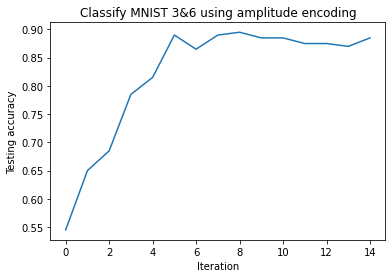

In [20]:
# using MNIST

# main parameters
training_data_num = 500
testing_data_num = 200
qubit_num = 4

# MNIST data with amplitude encoding, resized to 4*4
train_dataset = MNIST(mode='train', encoding='amplitude_encoding', num_qubits=qubit_num, classes=[3, 6],
                      data_num=training_data_num, need_cropping=True,
                      downscaling_method='resize', target_dimension=16, return_state=True)

val_dataset = MNIST(mode='test', encoding='amplitude_encoding', num_qubits=qubit_num, classes=[3, 6],
                    data_num=testing_data_num, need_cropping=True,
                    downscaling_method='resize', target_dimension=16,return_state=True)

quantum_train_x, train_y = train_dataset.quantum_image_states, train_dataset.labels
quantum_test_x, test_y = val_dataset.quantum_image_states, val_dataset.labels

acc = QClassifier2(
        quantum_train_x, # Training x
        train_y,         # Training y
        quantum_test_x,  # Testing x
        test_y,          # Testing y
        N = qubit_num,   # Number of qubits required
        DEPTH = 3,       # Circuit depth
        EPOCH = 5,       # Number of training epochs, the total iteration number "EPOCH * (Ntrain / BATCH)" is chosen to be about 200
        LR = 0.1,        # Set the learning rate
        BATCH = 40,      # Batch size during training
      )

plt.plot(acc)
plt.title("Classify MNIST 3&6 using amplitude encoding")
plt.xlabel("Iteration")
plt.ylabel("Testing accuracy")
plt.show()

_______

## References


[1] Mitarai, Kosuke, et al. Quantum circuit learning. [Physical Review A 98.3 (2018): 032309.](https://arxiv.org/abs/1803.00745)

[2] Farhi, Edward, and Hartmut Neven. Classification with quantum neural networks on near term processors. [arXiv preprint arXiv:1802.06002 (2018).](https://arxiv.org/abs/1802.06002)

[3] Schuld, Maria, et al. Circuit-centric quantum classifiers. [Physical Review A 101.3 (2020): 032308.](https://arxiv.org/abs/1804.00633)

[4] Schuld, Maria. Supervised quantum machine learning models are kernel methods. [arXiv preprint arXiv:2101.11020 (2021).](https://arxiv.org/pdf/2101.11020)